<a href="https://colab.research.google.com/github/gpbraun/projeto-probest/blob/main/src/projeto_probest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto do Curso

`COE241` - Estatística e Modelos Probabilísticos

`COS868` - Probabilidade e Estatística para Aprendizado de Máquina

Segundo Semestre de 2022

**Professora**: Rosa Maria Meri Leão

**Aluno**: Gabriel Pineschi Braun


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import namedtuple

## 1. Dataset

O objetivo deste trabalho é analisar um conjunto de dados aplicando a teoria aprendida em classe. E muito importante que seja realizada uma análise crítica dos resultados encontrados.

O projeto será baseado em dados reais fornecidos por um provedor de Internet de médio porte. Os dados representam a taxa de dados enviados em bps (taxa de upload) e a taxa de dados recebidos em bps (taxa de download) de/por um dispositivo na casa de um usuário do provedor. Dois tipos de dispositivos devem ser analisados: Smart-TV e Chromecast.

Dois arquivos contendo os dados serão disponibilizados:

1. dataset `chromecast.csv`
2. dataset `smart-tv.csv`

Cada arquivo possui os seguintes campos: `device_id`, `date_hour`, `bytes_up`, `bytes_down`. O campo `device_id` é o identificador único do dispositivo que está na casa de um usuário do provedor. O campo `date_hour` é a data e a hora em que a coleta de dados foi realizada com a granularidade de 1 minuto. Os campos `bytes_up` e `bytes_down` contém, respectivamente, as taxas em bps dos dados enviados (taxa de upload) e dos dados recebidos (taxa de download) pelo dispositivo em um minuto.


In [4]:
dataset_cast = pd.read_csv('dataset_chromecast.csv', parse_dates=[1])
dataset_smrt = pd.read_csv('dataset_smart-tv.csv', parse_dates=[1])


In [5]:
dataset_cast['device'] = 'chrome_cast'
dataset_smrt['device'] = 'smart_tv'

dataset = pd.concat([dataset_smrt, dataset_cast], ignore_index=True)


In [6]:
dataset['hour'] = dataset['date_hour'].dt.hour


**Reescalonar dados para $\log 10$**. Como os valores das taxas de upload e de download variam diversas ordens de grandeza, para calcular as estatísticas é necessário reescalonar as taxas para $\log$ na base $10$. Por exemplo, se o campo `bytes_up` é igual a $1000$, o valor que você deve usar para fazer as análises é 3.

In [7]:
dataset[['log_bytes_up', 'log_bytes_down']] = dataset[['bytes_up', 'bytes_down']].apply(lambda x: np.log10(x + 1))


In [8]:
LEGEND = {
    'chrome_cast': 'Chromecast',
    'smart_tv': 'Smart-TV',
    'bytes_up': 'upload',
    'bytes_down': 'download',
    'log_bytes_up': 'upload',
    'log_bytes_down': 'download',
    'mean': 'média',
    'median': 'mediana',
    'var': 'variância',
    'std': 'desvio padrão'
}


## 2. Estatísticas gerais

O objetivo desse estudo é avaliar os dados sem considerar o horário em que foram gerados, ou seja, você deve considerar todos os dados de cada um dos arquivos para obter as estatísticas descritas a seguir. Para cada tipo de dispositivo, Smart-TV e Chromecast, calcular: Histograma, Função Distribuição Empírica, Box Plot, Média, Variância e Desvio Padrão, para a taxa de upload e taxa de download.

Lembre-se que o tamanho do bin deve ser estimado de forma que o histograma represente de forma adequada os dados estudados. Use o **método de Sturges** apresentado em aula para estimar o tamanho do bin.

In [9]:
DataGeneral = namedtuple('DataGeneral', ['df', 'device', 'rate', 'values'])

def get_data_general(dataset):
    """Retorna os dados separados por dispositivo e por taxa (download/upload)."""
    for device in ['smart_tv', 'chrome_cast']:
        for rate in ['log_bytes_up', 'log_bytes_down']:
            df = dataset[dataset.device == device]
            values = df[rate]
            yield DataGeneral(df, device, rate, values)

data_general = list(get_data_general(dataset))


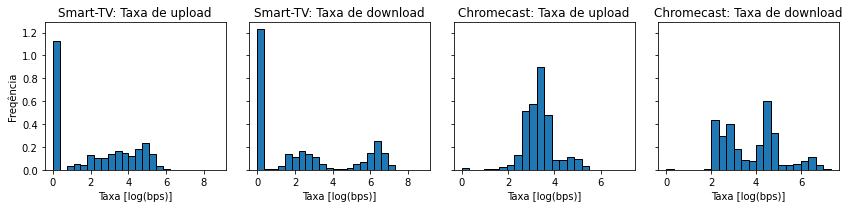

In [20]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(12, 3))
fig.subplots_adjust(wspace=0)

axs[0].set_ylabel("Freqência")

for ax, data in zip(axs, data_general):
    ax.set_title(f"{LEGEND[data.device]}: Taxa de {LEGEND[data.rate]}")
    ax.set_xlabel("Taxa [log(bps)]")
    
    ax.hist(data.values, density=True, bins='sturges', edgecolor="black")

fig.tight_layout()

fig.savefig("s1-hist.png", dpi=300)


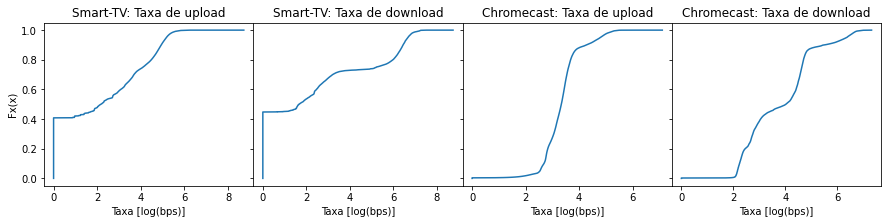

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
fig.subplots_adjust(wspace=0)

axs[0].set_ylabel("Fx(x)")

for ax, data in zip(axs.flat, data_general):
    ax.set_title(f"{LEGEND[data.device]}: Taxa de {LEGEND[data.rate]}")
    ax.set_xlabel("Taxa [log(bps)]")

    ecdf = ECDF(data.values)
    ax.plot(ecdf.x,ecdf.y)

fig.savefig("s1-ecdf.png")


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0, 0.5, 'Taxa [log(bps)]')

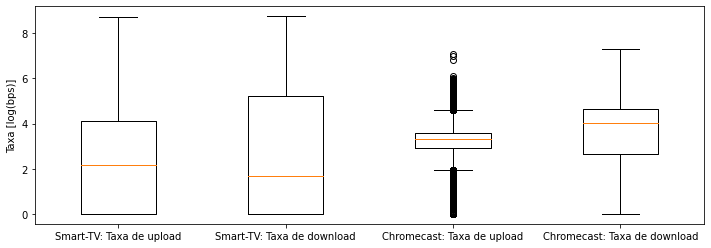

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))

axs.boxplot(
    [data.values for data in data_general],
    labels=[f"{LEGEND[data.device]}: Taxa de {LEGEND[data.rate]}" for data in data_general],
)

axs.set_ylabel("Taxa [log(bps)]")

fig.savefig("s1-boxplot.png")


Comente o que você observou a partir dos gráficos e sobre as diferenças e/ou similaridades entre os dois tipos de dispositivos. É importante interpretar os resultados obtidos.

## 3. Estatísticas por horário

O objetivo dessa análise é avaliar os dados considerando o horário em que foram gerados independente do dia. Você deve considerar os dados coletados em cada hora para cada tipo de dispositivo para obter as estatísticas descritas a seguir. Para cada tipo de dispositivo, Smart-TV e Chromecast, para cada hora calcular: Box Plot, Média, Variância e Desvio Padrão, para a taxa de upload e taxa de download. Neste item você deve gerar um box plot para cada tipo de dispositivo, para cada taxa coletada (upload e download), para cada hora. 

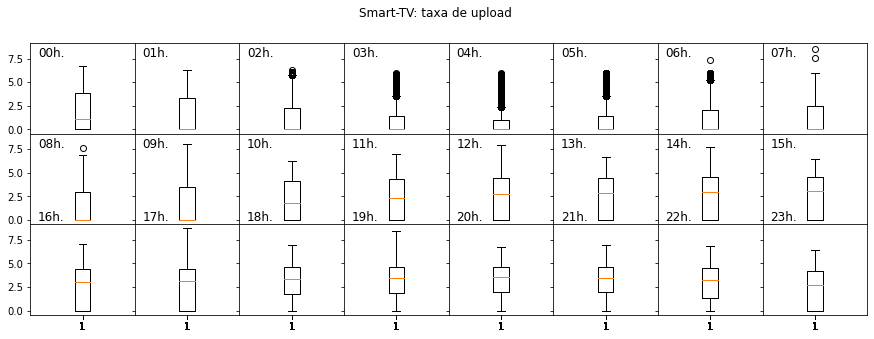

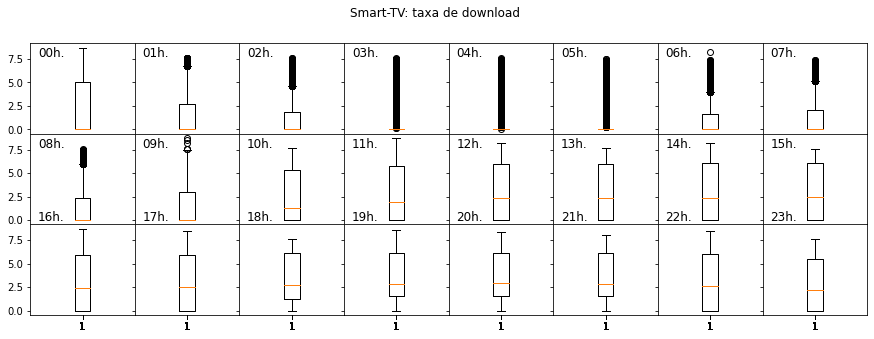

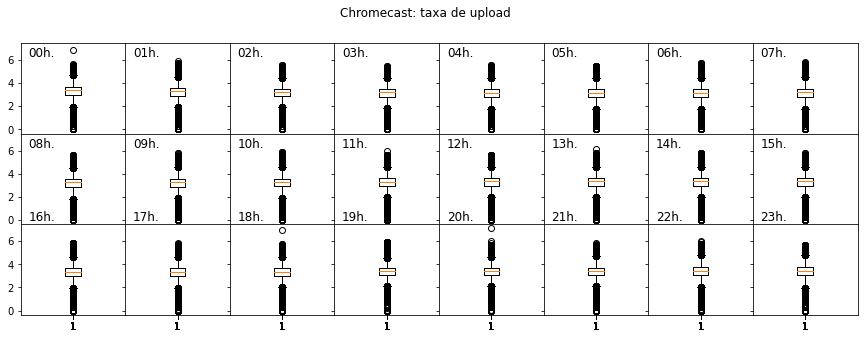

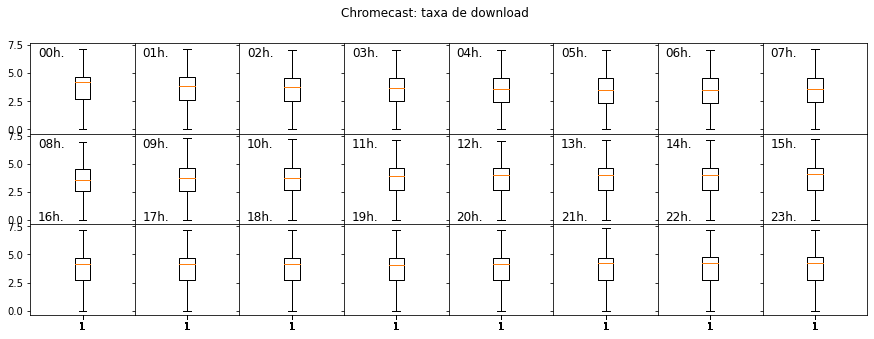

In [ ]:
for index, (df, device, rate, values) in enumerate(data_general):
    fig, axs = plt.subplots(3, 8, sharex=True, sharey=True, figsize=(15, 5)) # (24h)
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle(f"{LEGEND[device]}: taxa de {LEGEND[rate]}")

    for hour, ax in enumerate(axs.flat):
        data = df[df.hour == hour][rate]

        ax.set_title(f"{hour:02}h.", x=0.2, y=1.0, pad=-14)
        ax.boxplot(data)
    
    fig.savefig(f"s3-{index}.png")


Para a média, variância e desvio padrão, você deve fazer 4 gráficos, representando no eixo $x$ a hora e no eixo $y$ os valores das três estatíticas para cada taxa coletada, para cada tipo de dispositivo.

In [ ]:
DataHourGroup = namedtuple('DataHourGroup', ['df', 'df_hour_group', 'device', 'rate'])

def get_data_hour_group(dataset):
    """Retorna os dados separados por dispositivo e por taxa agrupados por hora."""
    for df, device, rate, values in get_data_general(dataset):
        df_hour_group = df.groupby(['hour'], as_index=False).agg(
            {key:['mean', 'median', 'std', 'var'] for key in ['log_bytes_up', 'log_bytes_down']}
        )
        yield DataHourGroup(df, df_hour_group, device, rate)


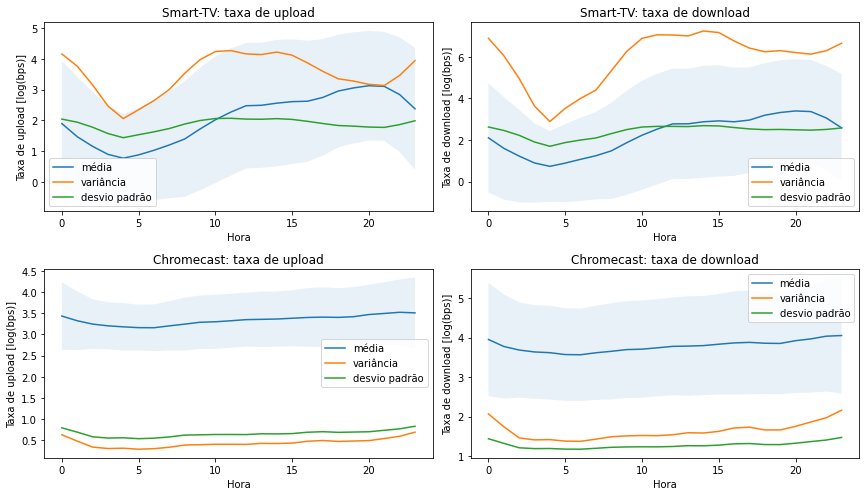

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

for ax, data in zip(axs.flat, get_data_hour_group(dataset)):
    ax.set_title(f"{LEGEND[data.device]}: taxa de {LEGEND[data.rate]}")
    ax.set_xlabel('Hora')
    ax.set_ylabel(f"Taxa de {LEGEND[data.rate]} [log(bps)]")

    x_values = data.df_hour_group['hour']
    y_values = {}
    for statistic in ['mean', 'var', 'std']:
        y_values[statistic] = data.df_hour_group[data.rate][statistic]
        ax.plot(x_values, y_values[statistic], label=LEGEND[statistic])

    ax.fill_between(x_values, y_values['mean'] - y_values['std'], y_values['mean'] + y_values['std'], alpha=0.1)

    ax.legend()

fig.tight_layout()

fig.savefig(f"s3-plots.png")



Faça uma análise dos resultados obtidos. Comente sobre as diferenças ou similaridades entre os dois tipos de dispositivos. O que você pode concluir a respeito das estatíticas obtidas por horário?

## 4. Caracterizando os horários com maior valor de tráfego

Neste item o objetivo é parametrizar uma ou mais distribuições da literatura para os dois horários com maior valor da mediana/média de cada taxa coletada para cada tipo de dispositivo.

### Passo 1

O **Passo 1** é escolher, a partir dos gráficos da seção 3, dois horários: um com maior valor de mediana e o outro com maior valor da média, para a taxa de upload e taxa de download, para cada tipo de dispositivo: Smart-TV e Chromecast.

Você terá 8 datasets, cada um contendo os dados com as seguintes características:

- Dataset 1: Horário com a maior mediana da taxa de upload em uma hora, Smart-TV
- Dataset 2: Horário com a maior média da taxa de upload em uma hora, Smart-TV
- Dataset 3: Horário com a maior mediana da taxa de download em uma hora, Smart-TV
- Dataset 4: Horário com a maior média da taxa de download em uma hora, Smart-TV
- Dataset 5: Horário com a maior mediana da taxa de upload em uma hora, Chromecast
- Dataset 6: Horário com a maior média da taxa de upload em uma hora, Chromecast
- Dataset 7: Horário com a maior mediana da taxa de download em uma hora, Chromecast
- Dataset 8: Horário com a maior média da taxa de download em uma hora, Chromecast


In [ ]:
DataHigherRate = namedtuple('DataHigherRate', ['df', 'device', 'rate', 'statistic', 'hour', 'values', 'norm', 'gamma'])

def get_data_higher_rate(dataset):
    """Retorna os 8 datasets da seção 4 em ordem."""
    for data in get_data_hour_group(dataset):
        for statistic in ['median', 'mean']:
            hour = data.df_hour_group[data.df_hour_group.index == data.df_hour_group[data.rate][statistic].idxmax()]['hour'].iloc[0]
            df_higher = data.df.loc[dataset.hour == hour]

            values = df_higher[data.rate]

            norm = stats.norm.fit(values, method="MLE")
            gamma = stats.gamma.fit(values, method="MLE")

            yield DataHigherRate(df_higher, data.device, data.rate, statistic, hour, values, norm, gamma)

data_higher_rate = list(get_data_higher_rate(dataset))


### Passos 2, 3 e 4

No **Passo 2**, faça um histograma para cada um dos 8 datasets. Lembre-se que você deve escolher o tamanho do bin usando o **método de Sturges**.

No Passo 3 calcule o maximum likelihood estimator (MLE) para estimar os parâmetros das seguintes distribuições: Gaussiana e Gamma, para cada um dos 8 datasets. Explique como você calculou o MLE.


No **Passo 4** você deve fazer um gráfico para cada um dos 8 datasets contendo 3 curvas: o histograma, a função densidade Gaussiana com os parâmetros obtidos com o MLE e a função densidade Gamma com os parâmetros obtidos com o MLE.

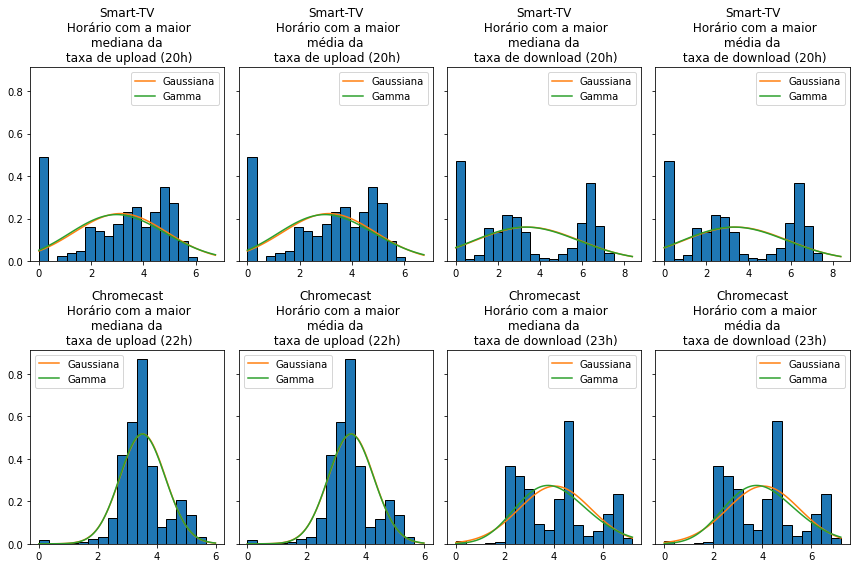

In [ ]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(12, 8))
fig.subplots_adjust(wspace=0)

for ax, data in zip(axs.flat, data_higher_rate):
    ax.set_title(f"{LEGEND[data.device]}\n Horário com a maior\n {LEGEND[data.statistic]} da \n taxa de {LEGEND[data.rate]} ({data.hour}h)")

    ax.hist(data.values, density='True', bins="sturges", edgecolor="black")

    x = np.linspace(min(data.values), max(data.values), 100)

    ax.plot(x, stats.norm.pdf(x, *data.norm), label="Gaussiana")
    ax.plot(x, stats.gamma.pdf(x, *data.gamma), label="Gamma")

    ax.legend()

fig.tight_layout()

fig.savefig(f"s4-4.png")


Observando os gráficos você deve comentar se existe ou não uma variável aleatória da literatura que possivelmente possa ser usada para representar os dados de cada um dos 8 datasets.

### Passo 5

O **Passo 5** consiste em fazer o gráfico *Probability Plot* comparando os dados de cada dataset com as distribuições parametrizadas. No total são 16 gráficos, comparando os dados reais dos 8 datasets com cada uma das duas distribuições parametrizadas.

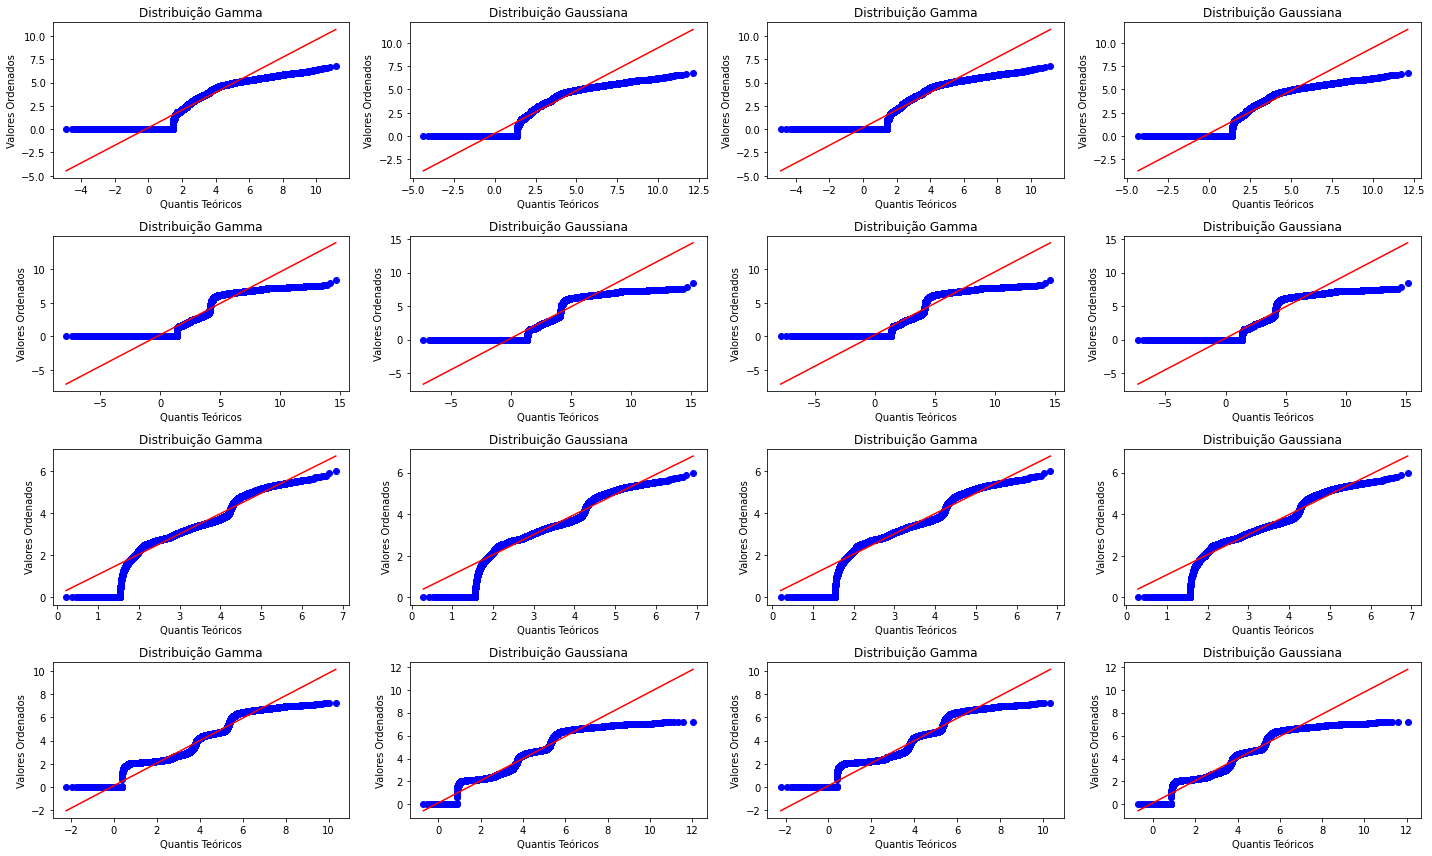

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 12))
fig.subplots_adjust(wspace=0)

for ax1, ax2, data in zip(axs.flat[::2], axs.flat[1::2], data_higher_rate):
    stats.probplot(data.values, dist=stats.norm, sparams=data.norm, plot=ax1)
    ax1.set_title('Distribuição Gamma')
    ax1.set_xlabel('Quantis Teóricos')
    ax1.set_ylabel('Valores Ordenados')

    stats.probplot(data.values, dist=stats.gamma, sparams=data.gamma, plot=ax2)
    ax2.set_title('Distribuição Gaussiana')
    ax2.set_xlabel('Quantis Teóricos')
    ax2.set_ylabel('Valores Ordenados')

fig.tight_layout()

fig.savefig(f"s4-5.png")


A partir dos resultados dessa seção você deve analisar as seguintes questões:

1. Quais foram os horários escolhidos para cada dataset?
2. O que você pôde observar a partir dos histogramas dos datasets?
3. Comente sobre as diferenças e/ou similaridades entre os datasets 1 e 2, 3 e 4, 5 e 6, 7 e 8.
8. O objetivo é comparar as características dos datasets com a maior mediana em um
determinado horário com os datasets com a maior média em um determinado horário.
4. É possível caracterizar os datasets acima por uma variável aleatória da literatura?
5. Se a resposta for não, qual o motivo?
6. O que você pode observar a partir dos gráficos *Probability Plot*?


## 5. Análise da correlação entre as taxas de upload e download para os horários com o maior valor de tráfego

Você deve calcular o coeficiente de correlação amostral e fazer o gráfico scatter plot comparando as taxas dos seguintes datasets:

- dataset 1 e dataset 3
- dataset 2 e dataset 4
- dataset 5 e dataset 7
- dataset 6 e dataset 8



In [ ]:
def get_rate_comparisson_data(data_higher_rate):
    """Retorna as 4 duplas de datasets da seção 5 em ordem."""
    for i in [0, 1, 4, 5]:
        yield data_higher_rate[i], data_higher_rate[i+2]


(212608,) (212608,)
(212608,) (212608,)
(76738,) (71848,)
(76738,) (71848,)


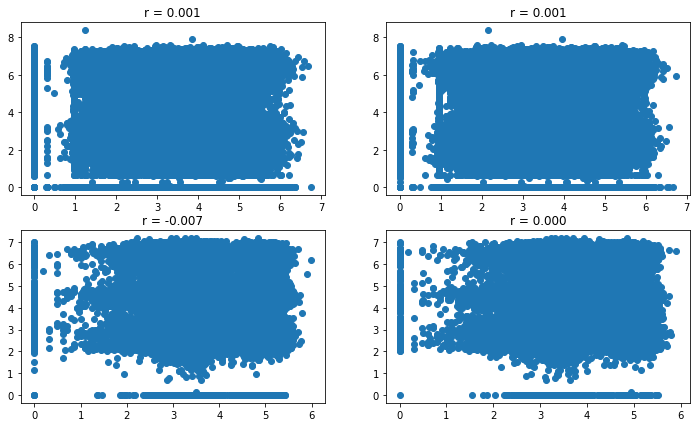

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

for (data1, data2), ax in zip(get_rate_comparisson_data(data_higher_rate), axs.flat):
    print(data1.values.shape, data2.values.shape)
    num_values = min(data1.values.shape, data2.values.shape)[0]

    data1_sample = data1.values.sample(n=num_values)
    data2_sample = data2.values.sample(n=num_values)

    ax.set_title(f"r = {stats.pearsonr(data1_sample, data2_sample)[0]:.3f}")

    ax.scatter(data1_sample, data2_sample)

fig.savefig(f"s5.png")


Você deve analisar os resultados e indicar se existe alguma correlação entre as taxas de download e upload dos dispositivos.

## 6. Comparação dos dados gerados pelos dispositivos SmartTV e Chromecast

O objetivo deste estudo é avaliar se os dois dispositivos que são usados prioritariamente
para assistir vídeo, possuem distribuição de probabilidade das taxas de upload e download
semelhante nos horários de maior tráfego. Você deve usar a estatística G do teste Chi-Square for goodness of fit (apresentado em classe) para fazer essa análise. Esse teste também é
chamado de [G-test](https://en.wikipedia.org/wiki/G-test).

Você deve realizar o G-test comparando as taxas dos seguintes datasets

- dataset 1 e dataset 5
- dataset 2 e dataset 6
- dataset 3 e dataset 7
- dataset 4 e dataset 8

Note que para realizar o G-test entre cada par de datasets, o número de bins e os valores dos bins dos histogramas dos datasets a serem comparados devem ser os mesmos. Portanto se os bins dos histogramas que você obteve na seção 4 para um determinado par de datasets for diferente, escolha o número de bins e os valores dos bins de um deles e use como referência para aquele par de datasets.

In [ ]:
def get_device_comparisson_data(data_higher_rate):
    """Retorna as 4 duplas de datasets da seção 6 em ordem."""
    for i in range(4):
        yield data_higher_rate[i], data_higher_rate[i+4]


In [ ]:
for data1, data2 in get_device_comparisson_data(data_higher_rate):
    print(f"Comparação", end=" ")

    bin_edges = 'sturges'

    print(f"{LEGEND[data1.device]}: taxa de {LEGEND[data1.rate]} com maior {LEGEND[data2.statistic]}", end=" e ")
    hist_1, bin_edges = np.histogram(dataset[dataset.device == data1.device][data1.rate], bins=bin_edges, density=True)

    print(f"{LEGEND[data2.device]}: taxa de {LEGEND[data2.rate]} com maior {LEGEND[data2.statistic]}")
    hist_2, bin_edges = np.histogram(dataset[dataset.device == data2.device][data2.rate], bins=bin_edges, density=True)

    values = np.array([hist_1, hist_2])

    res = stats.chi2_contingency(values, lambda_="log-likelihood")

    print(f"Estatística: {res[0]}, p-value: {res[1]}")


Comparação Smart-TV: taxa de upload com maior mediana e Chromecast: taxa de upload com maior mediana
Estatística: 2.949437569994508, p-value: 0.9999998350180705
Comparação Smart-TV: taxa de upload com maior média e Chromecast: taxa de upload com maior média
Estatística: 2.949437569994508, p-value: 0.9999998350180705
Comparação Smart-TV: taxa de download com maior mediana e Chromecast: taxa de download com maior mediana
Estatística: 3.592445533081407, p-value: 0.9999988105703735
Comparação Smart-TV: taxa de download com maior média e Chromecast: taxa de download com maior média
Estatística: 3.592445533081407, p-value: 0.9999988105703735


## 7. Relatório

Você deve fazer um relatório contendo todos os resultados que você obteve e explicando como
você os obteve. É importante comentar cada um dos resultados e explicar se o resultado que você obteve poderá auxiliar o provedor de serviço de Internet a entender os dados que passam pela sua rede. A avaliação do projeto será feita com base na qualidade do relatório.

Você deve fazer upload do seu relatório (arquivo pdf) na plataforma do Google Classroom na atividade Projeto do Curso.

No relatório deve estar indicado um link para o código que você usou para obter os resultados do trabalho.